In [1]:
import os
import pickle
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable

import data
from model import *
from trainer import *

## Initialize data

In [2]:
corpus = data.Corpus('./data/ptb')
ntokens = len(corpus.dictionary)

## Hyperparameters

In [3]:
model_test_name = '2_encoder_1_decoder'
ckpt_loc = os.path.join('checkpoints', model_test_name+'.pt')

# Training hyperparameters
eval_batch_size = 10
batch_size = 74
seq_len = 18
dropout = 0.1
clip = 4
lr = 0.005
warmup_steps = 3
decay_factor = 0.5
smoothing = 0.05

epochs = 150
early_stopping = 10
log_interval = 150  # Print log every `log_interval` batches

In [4]:
# Model hyperparameters
embed_size = 512
encode_size = 256
h_size = 256
align_size = 256
decode_size = 256
decode_out_size = 512
n_enc_layers = 2
attn_rnn_layers = 1
n_dec_layers = 1
smooth_align = True
align_location = False
skip_connections = False

## Initialize model, criterion, optimizer, and learning rate scheduler

The learning rate scheduler sets the learning rate factor according to:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{epoch}^{-0.5}, \text{epoch}\cdot\text{warmup}^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first $\text{warmup}$ epochs, then decreasing it proportionally to the inverse square root of the epoch number.

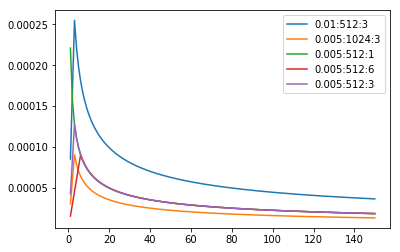

In [5]:
lrate = lambda factor, h_size, warmup: lambda e: factor*(h_size**(-0.5) * min(e**(-decay_factor), e * warmup**(-(decay_factor+1))))
opts = [
    lrate(2*lr, embed_size, warmup_steps), 
    lrate(lr, embed_size*2, warmup_steps),
    lrate(lr, embed_size, warmup_steps//2),
    lrate(lr, embed_size, warmup_steps*2),
    lrate(lr, embed_size, warmup_steps),
]
plt.plot(np.arange(1, epochs+1), [[opt(i) for opt in opts] for i in range(1, epochs+1)])
plt.legend([
    "%.4g:%d:%d" % (2*lr, embed_size, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size*2, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps//2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps*2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps),
])

In [6]:
model = RNNModel(
    src_vocab = ntokens, tgt_vocab = ntokens, embed_size = embed_size,
    encode_size = encode_size, h_size = h_size, align_size = align_size,
    decode_size = decode_size, decode_out_size = decode_out_size,
    n_enc_layers = n_enc_layers, attn_rnn_layers = attn_rnn_layers,
    n_dec_layers = n_dec_layers, align_location = align_location,
    smooth_align = smooth_align, skip_connections = skip_connections,
    dropout = dropout
)
criterion = LabelSmoothing(ntokens, smoothing = smoothing)
eval_criterion = LabelSmoothing(ntokens, smoothing = 0)
optimizer = optim.Adam(
    model.parameters(), lr = lr, betas = (0.9, 0.98), eps = 1e-9
)
lr_scheduler = get_lr_scheduler(embed_size, warmup_steps, decay_factor, optimizer)
# Reference
nparams = sum([p.numel() for p in model.parameters()])
print('Model parameters: %d' % nparams)

Model parameters: 9128705


## Train
Ready the data

In [7]:
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)
train_data.size(), val_data.size(), test_data.size()

(torch.Size([12562, 74]), torch.Size([7376, 10]), torch.Size([8243, 10]))

Train and evaluate

In [8]:
train_stats, stat, train_loss, data, targets, states, nstates = train_eval_loop(
    model, train_data, val_data, batch_size, eval_batch_size,
    seq_len, ntokens, criterion, eval_criterion, optimizer,
    lr_scheduler, epochs, warmup_steps, early_stopping,
    clip, log_interval, ckpt_loc
)

Epoch   1/150) lr = 4.253e-05 (warmup)
 b 150/726 >> 3927.4 ms/b | lr: 4.369e-05 | grad norm:  0.96 | inf norm:  0.028 | loss: 7.34 | perp: 1540.22
 b 300/726 >> 3825.4 ms/b | lr: 4.369e-05 | grad norm:  0.59 | inf norm:  0.014 | loss: 6.20 | perp: 492.02
 b 450/726 >> 3794.2 ms/b | lr: 4.483e-05 | grad norm:  0.63 | inf norm:  0.013 | loss: 6.17 | perp: 478.16
 b 600/726 >> 3702.8 ms/b | lr: 4.253e-05 | grad norm:  0.60 | inf norm:  0.013 | loss: 6.18 | perp: 480.65
------------------------------------------------------------------------------------------------------------
Elapsed time: 2721.58 sec | train loss, perp: 6.421, 614.77    | valid loss, perp: 6.529, 684.86   
Grad norm:  0.499 | Grad inf. norm:  0.0105 | Max abs param:  0.1574


Epoch   2/150) lr = 8.505e-05 (warmup)
 b 150/722 >> 3130.8 ms/b | lr: 8.738e-05 | grad norm:  0.62 | inf norm:  0.017 | loss: 6.21 | perp: 497.66
 b 300/722 >> 2911.8 ms/b | lr: 9.187e-05 | grad norm:  0.58 | inf norm:  0.015 | loss: 6.13 | perp: 

Epoch  11/150) lr = 6.663e-05
 b 150/715 >> 2932.6 ms/b | lr: 7.196e-05 | grad norm:  4.06 | inf norm:  0.100 | loss: 5.29 | perp: 198.60
 b 300/715 >> 2803.9 ms/b | lr: 6.845e-05 | grad norm:  2.41 | inf norm:  0.049 | loss: 5.24 | perp: 189.42
 b 450/715 >> 2710.4 ms/b | lr: 6.845e-05 | grad norm:  1.88 | inf norm:  0.039 | loss: 5.18 | perp: 177.26
 b 600/715 >> 2693.5 ms/b | lr: 6.845e-05 | grad norm:  4.11 | inf norm:  0.076 | loss: 5.18 | perp: 177.44
------------------------------------------------------------------------------------------------------------
Elapsed time: 1969.30 sec | train loss, perp: 5.214, 183.86    | valid loss, perp: 5.531, 252.39 :(
Grad norm:  8.162 | Grad inf. norm:  0.1780 | Max abs param:  0.3959


Epoch  12/150) lr = 6.379e-05
 b 150/717 >> 2645.0 ms/b | lr: 6.554e-05 | grad norm:  2.91 | inf norm:  0.074 | loss: 5.18 | perp: 177.07
 b 300/717 >> 2632.1 ms/b | lr: 6.379e-05 | grad norm:  2.86 | inf norm:  0.066 | loss: 5.13 | perp: 169.31
 b 450/717 >

Epoch  21/150) lr = 4.822e-05
 b 150/716 >> 2859.6 ms/b | lr: 4.253e-05 | grad norm:  2.45 | inf norm:  0.099 | loss: 4.74 | perp: 114.09
 b 300/716 >> 3658.6 ms/b | lr: 5.083e-05 | grad norm:  7.03 | inf norm:  0.278 | loss: 4.65 | perp: 104.71
 b 450/716 >> 4164.1 ms/b | lr: 4.546e-05 | grad norm:  2.42 | inf norm:  0.068 | loss: 4.68 | perp: 108.03
 b 600/716 >> 4058.1 ms/b | lr: 4.253e-05 | grad norm:  7.39 | inf norm:  0.204 | loss: 4.56 | perp:  95.72
------------------------------------------------------------------------------------------------------------
Elapsed time: 2601.35 sec | train loss, perp: 4.658, 105.39    | valid loss, perp: 4.530,  92.80   
Grad norm:  4.190 | Grad inf. norm:  0.1144 | Max abs param:  0.5401


Epoch  22/150) lr = 4.711e-05
 b 150/719 >> 3010.6 ms/b | lr: 5.089e-05 | grad norm:  3.44 | inf norm:  0.088 | loss: 4.76 | perp: 116.43
 b 300/719 >> 2764.7 ms/b | lr: 4.442e-05 | grad norm:  8.96 | inf norm:  0.232 | loss: 4.62 | perp: 101.41
 b 450/719 >

Epoch  31/150) lr = 3.969e-05
 b 150/720 >> 2601.3 ms/b | lr: 3.969e-05 | grad norm: 12.09 | inf norm:  0.365 | loss: 4.33 | perp:  75.60
 b 300/720 >> 2542.7 ms/b | lr: 3.742e-05 | grad norm: 17.84 | inf norm:  0.455 | loss: 4.26 | perp:  70.81
 b 450/720 >> 2593.7 ms/b | lr: 4.183e-05 | grad norm: 18.05 | inf norm:  0.545 | loss: 4.36 | perp:  78.59
 b 600/720 >> 2615.9 ms/b | lr: 3.857e-05 | grad norm:  4.20 | inf norm:  0.128 | loss: 4.31 | perp:  74.52
------------------------------------------------------------------------------------------------------------
Elapsed time: 1867.41 sec | train loss, perp: 4.304,  73.98    | valid loss, perp: 4.070,  58.56   
Grad norm:  3.581 | Grad inf. norm:  0.1501 | Max abs param:  0.7914


Epoch  32/150) lr = 3.906e-05
 b 150/713 >> 2594.2 ms/b | lr: 3.906e-05 | grad norm: 13.66 | inf norm:  0.401 | loss: 4.36 | perp:  78.09
 b 300/713 >> 2683.7 ms/b | lr: 4.013e-05 | grad norm:  9.56 | inf norm:  0.220 | loss: 4.57 | perp:  96.12
 b 450/713 >

Epoch  41/150) lr = 3.451e-05
 b 150/718 >> 2647.7 ms/b | lr:  3.15e-05 | grad norm:  6.59 | inf norm:  0.262 | loss: 4.04 | perp:  56.57
 b 300/718 >> 2599.9 ms/b | lr: 3.638e-05 | grad norm: 18.22 | inf norm:  0.533 | loss: 4.04 | perp:  56.95
 b 450/718 >> 2567.1 ms/b | lr: 3.727e-05 | grad norm: 11.89 | inf norm:  0.338 | loss: 3.91 | perp:  50.04
 b 600/718 >> 2623.6 ms/b | lr: 3.546e-05 | grad norm:  3.72 | inf norm:  0.090 | loss: 4.05 | perp:  57.22
------------------------------------------------------------------------------------------------------------
Elapsed time: 1868.62 sec | train loss, perp: 4.018,  55.60    | valid loss, perp: 3.705,  40.66   
Grad norm:  4.967 | Grad inf. norm:  0.1705 | Max abs param:  1.0045


Epoch  42/150) lr = 3.41e-05
 b 150/716 >> 2645.0 ms/b | lr: 3.503e-05 | grad norm: 34.18 | inf norm:  1.297 | loss: 4.28 | perp:  71.96
 b 300/716 >> 2551.8 ms/b | lr:  3.77e-05 | grad norm: 24.11 | inf norm:  0.852 | loss: 4.00 | perp:  54.37
 b 450/716 >>

 b 150/715 >> 4124.1 ms/b | lr: 3.007e-05 | grad norm:  5.85 | inf norm:  0.179 | loss: 3.83 | perp:  45.95
 b 300/715 >> 4068.0 ms/b | lr: 2.825e-05 | grad norm:  6.93 | inf norm:  0.181 | loss: 3.85 | perp:  46.85
 b 450/715 >> 4088.5 ms/b | lr: 3.262e-05 | grad norm: 17.49 | inf norm:  0.575 | loss: 3.77 | perp:  43.25
 b 600/715 >> 3867.4 ms/b | lr: 3.421e-05 | grad norm:  5.28 | inf norm:  0.149 | loss: 3.62 | perp:  37.27
------------------------------------------------------------------------------------------------------------
Elapsed time: 2773.98 sec | train loss, perp: 3.752,  42.60    | valid loss, perp: 3.443,  31.29   
Grad norm:  3.606 | Grad inf. norm:  0.1245 | Max abs param:  1.1856


Epoch  52/150) lr = 3.064e-05
 b 150/716 >> 3006.9 ms/b | lr: 2.702e-05 | grad norm:  5.45 | inf norm:  0.180 | loss: 3.98 | perp:  53.50
 b 300/716 >> 2781.7 ms/b | lr: 2.604e-05 | grad norm:  5.52 | inf norm:  0.284 | loss: 3.66 | perp:  38.80
 b 450/716 >> 2789.7 ms/b | lr: 2.978e-05 

 b 150/716 >> 3736.8 ms/b | lr: 2.982e-05 | grad norm: 32.27 | inf norm:  1.183 | loss: 3.73 | perp:  41.65
 b 300/716 >> 2887.4 ms/b | lr: 3.056e-05 | grad norm: 33.71 | inf norm:  0.963 | loss: 3.83 | perp:  45.91
 b 450/716 >> 2799.8 ms/b | lr: 2.583e-05 | grad norm:  6.56 | inf norm:  0.187 | loss: 3.71 | perp:  40.69
 b 600/716 >> 2909.4 ms/b | lr: 2.982e-05 | grad norm: 21.68 | inf norm:  0.554 | loss: 3.49 | perp:  32.69


RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at C:\Anaconda2\conda-bld\pytorch_1513133520683\work\torch\lib\TH\THGeneral.c:246

In [ ]:
CAUSES = ['output', 'grad']
if stat in list(range(len(CAUSES))):
    params = [p for p in model.parameters() if p.grad is not None]
    print(any([np.isnan(p.data).any() for p in params]), any([np.isnan(p.grad.data).any() for p in params]))
    
    _states = states
    if model.n_enc_layers > 0:
        enc_states = states[0]
        states = states[1:]
    if model.n_dec_layers > 0:
        dec_states = states[-1]
        states = states[:-1]
    attn_states = states[0]
    relu = nn.ReLU()
    log_softmax = nn.LogSoftmax(dim = -1)
    
    embeddings = model.embedding(data)
    enc_out, new_enc_states = model.encoders(model.drop(embeddings))
    attn_out, new_attn_states = model.attn(enc_out, attn_states)
    dec_out, new_dec_states = model.decoders(relu(attn_out))
    output = model.projection(dec_out)
    
    print([
        np.isnan(p.data).any() for p in [embeddings, enc_out, attn_out, dec_out, output]
    ])
else:
    # Save training stats
    with open(os.path.join('stats', model_test_name+'.pkl'), 'wb') as f:
        pickle.dump(train_stats, f)
    with open(os.path.join('models', model_test_name+'.pt'), 'wb') as f:
        torch.save(model.state_dict(), f)

In [ ]:
test_loss = evaluate(
    model, test_data, eval_batch_size, seq_len,
    ntokens, eval_criterion, save_wts = True
)
print('test_loss: {:5.3f} | test_perplexity: {:7.2f}'.format(
    test_loss, np.exp(test_loss)
))

## Evaluate predictions

In [ ]:
nb = 4
model.eval(save_wts = True)
# Get some data from a random point in the test_data set
states = model.init_states(nb)
data, targets = get_batch(test_data, 120, seq_len, evaluate = True)
data = data[:,:nb].contiguous()
targets = targets.view(seq_len, -1)[:,:nb].contiguous()

In [ ]:
# Run the model forward
output, states = model(data, states)
# Convert the output log probabilities to normal probabilities
output = output.exp()
# Get the argmax of each step in the output
output_p, output_idx = output.max(dim = -1)

Compare the predicted output word indices to the targets

In [ ]:
targets = targets.t()
output_idx = output_idx.t()
for i in range(nb):
    # Print the output with the targets
    seqs = torch.cat([targets[i].unsqueeze(0), output_idx[i].unsqueeze(0)], 0)
    # Number incorrectly predicted
    num_incorrect = (targets[i] != output_idx[i]).sum()
    print('%d incorrectly predicted\n' % num_incorrect[0], seqs)

## Visualizations

Some basic weight heat maps to start:

In [ ]:
embed_wts = np.array(model.embedding.weight.data)
embed_norm = (embed_wts - embed_wts.mean()) / (embed_wts.max() - embed_wts.min())
plt.imshow(embed_norm, aspect = 'auto', cmap = 'jet')
plt.xlabel('dim'); plt.ylabel('word index');
plt.title('Embedding layer')
plt.colorbar()
embed_wts.shape

In [ ]:
attn = model.attn

In [ ]:
align_wts = np.array(attn.alignment.weight.data)
plt.imshow(align_wts, aspect = 'auto', cmap = 'jet')
plt.xlabel('d_align_in'); plt.ylabel('d_align_out')
plt.title('Alignment sublayer weights')
plt.colorbar()
align_wts.shape

In [ ]:
attn_wts = np.array(attn.attention.weight.data)
attn_norm = (attn_wts - attn_wts.mean()) / (attn_wts.max() - attn_wts.min())
plt.imshow(attn_wts, aspect = 'auto', cmap = 'jet')
plt.xlabel('d_input+d_state'); plt.ylabel('d_output')
plt.title('Attention sublayer weights (in attention mechanism)')
plt.colorbar()
attn_wts.shape

Sequence attention visualization by mapping the alignment weights (in the attention mechanism) at each step of the input:

In [ ]:
cols = 2
rows = nb//cols
fig, axs = plt.subplots(rows, cols, figsize = (30, 20))
for b in range(nb):
    wts = attn.attn_wts[:,b,:]
    wts_mean = wts.mean()
    wts_max = wts.max()
    wts_min = wts.min()
    norm = (wts - wts_mean) / (wts_max - wts_min)
    r = b // cols
    c = b % cols
    ax = axs[r, c]
    im = ax.imshow(wts, aspect = 'auto', cmap = 'jet')
    # Fix labels
    xlabels = list(targets[b].data)
    ax.set_xticks(range(seq_len))
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('Targets')
    ylabels = list(data[:,b].data)
    ax.set_yticks(range(seq_len))
    ax.set_yticklabels(ylabels)
    ax.set_ylabel('Inputs')
    ax.set_title('Example %d' % b)
    fig.colorbar(im, ax = ax)
plt.show()

## Plot training stat curves

In [ ]:
epoch_range = range(1, train_stats['epochs']+1)
train_stats.keys()

In [ ]:
plt.plot(epoch_range, train_stats['train_loss'])
plt.plot(epoch_range, train_stats['val_loss'])
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss over training time')
plt.legend(['Train', 'Validation'])

In [ ]:
plt.plot(epoch_range, train_stats['max_param'])
plt.xlabel('Epoch'); plt.ylabel('Largest parameter magnitude')
plt.title('Largest parameter magnitude over training time')

In [ ]:
fig, pnorm_ax = plt.subplots()
pnorm_ax.plot(epoch_range, train_stats['grad_norm'], 'b')
pnorm_ax.set_xlabel('Epoch');
pnorm_ax.set_ylabel('2-norm', color = 'b')

infnorm_ax = pnorm_ax.twinx()
infnorm_ax.plot(epoch_range, train_stats['grad_inf_norm'], 'r')
infnorm_ax.set_ylabel('infinite norm', color = 'r')

plt.title('Gradient norms over training time')
#fig.tight_layout()